# Xylariaceae analysis

We will use our combined biom table of leaf and wood endophytes to ask some questions about the roles of both leaf- and sapwood-inhabiting endophytes on nearby stromata, focusing on the family Xylariaceae.

<a id='contents'></a>

## Contents

[Importing biom table and setup](#import)  
[Negative control cleanup](#nc)  
[Positive controls](#pos)  
[Variance Stabilization of Read Counts](#deseq)  
[Formatting and transforming data for RDA](#rdaprep)  
[Redundancy analysis](#rda)  

<a id='import'></a>

## Importing biom table and setup

Let's get the proper packages and import our biom table.

In [1]:
library('phyloseq')
library('DESeq2')
library('repr')
library('vegan')

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:base’:

    c

Import our biom tables. We used the green genes style of formatting for our taxonomy metadata, I think...

In [2]:
biom95 <- import_biom('combo_95_wMeta.biom', parseFunction=parse_taxonomy_greengenes)

In [3]:
biom97 <- import_biom('combo_97_wMeta.biom', parseFunction=parse_taxonomy_greengenes)

Our biom table:

In [4]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

Here is our current metadata for samples. We can subset by library type (leaf or wood), sample or control, and sample number. The unique identifiers (first column) were the name of the sample assigned by the illumina software.

In [5]:
head(sample_data(biom95))

,Library,SampleNumber,SorC
160wood,W,Dc-X,Control
161wood,W,Dc-PosG,Control
162wood,W,Dc-PosI,Control
163wood,W,Dc-Neg,Control
164wood,W,1,Sample
165wood,W,2,Sample


In [6]:
head(sample_data(biom97))

,SampleNumber,SorC,Library
160wood,Dc-X,Control,W
161wood,Dc-PosG,Control,W
162wood,Dc-PosI,Control,W
163wood,Dc-Neg,Control,W
164wood,1,Sample,W
165wood,2,Sample,W


Odd that the biom table metadata assignment process changes the order of the metadata columns. But looks okay.

<a id='nc'></a>

## Cleanup of biom tables using negative controls

Okay, as per the recommendations of [Nguyen 2015](http://onlinelibrary.wiley.com/doi/10.1111/nph.12923/full), we'll remove sequences of OTUs found in our negative controls, up to the amount of reads found for these OTUs in our negative controls. 

What do we find in our negatives? Make a phyloseq object of just our wood negative:

In [7]:
neg95 <- subset_samples(biom95, SampleNumber=='Neg')

In [8]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

How many contaminants do we have? Total reads:

In [9]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1759

Which OTUs, and how many of each?

In [10]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU116:65Leaf     OTU89:65Leaf  OTU1767:163wood OTU247:112.2Leaf 
             544               98                1               40 
  OTU667:114Leaf   OTU254:161wood   OTU737:164wood   OTU139:161wood 
              61                1               69                3 
   OTU127:12Leaf   OTU181:104Leaf   OTU285:161wood   OTU234:161wood 
               1               56              109                2 
  OTU210:161wood   OTU155:122Leaf    OTU230:70Leaf   OTU304:161wood 
               1                2                1              109 
  OTU246:161wood   OTU491:161wood   OTU825:192wood     OTU97:51Leaf 
               1               51                1                1 
  OTU339:167wood   OTU361:164wood   OTU391:164wood   OTU282:165wood 
               1               20                1                1 
    OTU67:14Leaf   OTU356:173wood    OTU252:35Leaf     OTU68:55Leaf 
               1                1                1                1 
   OTU69:100Leaf   OTU567:132Leaf  OTU1231:103Leaf  OTU1473:172wood 
               1                1               36               64 
  OTU288:167wood    OTU216:90Leaf  OTU1322:170wood  OTU2396:168wood 
             185                1                4                4 
  OTU789:254wood   OTU113:194wood   OTU2872:34Leaf  OTU1483:255wood 
               1               13                1               50 
 OTU1108:125Leaf   OTU848:121Leaf  OTU1143:172wood  OTU1806:252wood 
               1               60               48                1 
 OTU1376:240wood   OTU5194:51Leaf  OTU8517:173wood    OTU770:48Leaf 
              32               23                1                1 
  OTU518:190wood  OTU1591:183wood  OTU1228:199wood    OTU80:207wood 
               1                1               44                3 
  OTU808:252wood  OTU1816:253wood 
               1                2

A quick visual summary of the top 15 contaminants:

In [11]:
aa <- taxa_sums(neg95)[taxa_sums(neg95)>0]
aa <- sort(aa, decreasing = TRUE)[1:15]
neg95_top15 <- prune_taxa(names(aa), neg95)

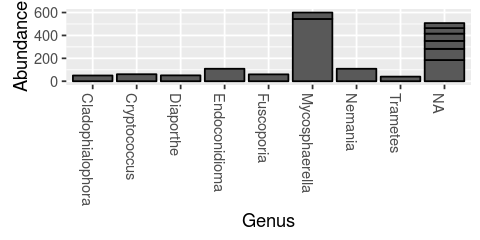

In [12]:
options(repr.plot.width = 4, repr.plot.height = 2) ## using repr to control size of R plotter outputs
plot_bar(neg95_top15, "Genus")

This stacks OTUs in the same taxonomic category into a single column. Hence, two OTUs assigned to *Mycosphaerella* are stacked, and 6 unidentified OTUs are stacked into the final bin. 

So, we can subtract the sequence quantities found in our negative control from all other samples by digging into the architecture of our phyloseq objects. If we look at our biom95 object, we can see that our read counts are stored in a matrix-like object in the otu_table slot:

In [11]:
str(biom95)

Formal class 'phyloseq' [package "phyloseq"] with 5 slots
  ..@ otu_table:Formal class 'otu_table' [package "phyloseq"] with 2 slots
  .. .. ..@ .Data        : num [1:10271, 1:232] 70976 4 2 318 8 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:10271] "OTU1:X_hypoxylon_Oregon" "OTU7654:160wood" "OTU2438:53Leaf" "OTU541:114Leaf" ...
  .. .. .. .. ..$ : chr [1:232] "160wood" "161wood" "162wood" "163wood" ...
  .. .. ..@ taxa_are_rows: logi TRUE
  ..@ tax_table:Formal class 'taxonomyTable' [package "phyloseq"] with 1 slot
  .. .. ..@ .Data: chr [1:10271, 1:7] "Fungi" "Fungi" "Fungi" "Fungi" ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:10271] "OTU1:X_hypoxylon_Oregon" "OTU7654:160wood" "OTU2438:53Leaf" "OTU541:114Leaf" ...
  .. .. .. .. ..$ : chr [1:7] "Kingdom" "Phylum" "Class" "Order" ...
  ..@ sam_data :'data.frame':	232 obs. of  3 variables:
Formal class 'sample_data' [package "phyloseq"] with 4 slots
  .. .. ..@ .Data    :List

To subtract the negative control reads from the others, we can treat these objects like matrices and subtract the column of the negative control from all other columns. In this case, we need to subtract the wood column negative control from the wood samples, and the leaf negative controls from the leaves (there are two). 

In [13]:
## make a phyloseq object, in case we mess something up:
biom95.nonc <- biom95
biom97.nonc <- biom97

Wood samples:

In [14]:
## subset our wood samples
wood95 <- subset_samples(biom95, Library=='W')
wood97 <- subset_samples(biom97, Library=='W')

## subset our wood negative
woodneg95 <- subset_samples(biom95, SampleNumber=='Neg') 
woodneg97 <- subset_samples(biom97, SampleNumber=='Neg') 

## subtract out wood negative controls
wood95@otu_table@.Data <- wood95@otu_table@.Data - woodneg95@otu_table@.Data[,1] 
wood97@otu_table@.Data <- wood97@otu_table@.Data - woodneg97@otu_table@.Data[,1] 

Leaf samples:

In [15]:
## leaves only
leaf95 <- subset_samples(biom95, Library=='L')  
leaf97 <- subset_samples(biom97, Library=='L')  
## leaf negative controls
leafneg95 <- subset_samples(biom95, SampleNumber=='NC_1' | SampleNumber=='NC_2') 
leafneg97 <- subset_samples(biom97, SampleNumber=='NC_1' | SampleNumber=='NC_2') 
## subtract out the controls
leaf95@otu_table@.Data <- leaf95@otu_table@.Data - leafneg95@otu_table@.Data[,1] - leafneg95@otu_table@.Data[,2] 
leaf97@otu_table@.Data <- leaf97@otu_table@.Data - leafneg97@otu_table@.Data[,1] - leafneg97@otu_table@.Data[,2] 

Now reassemble these, plus the stromata abundance column. Negative numbers are reassigned a zero value:

In [16]:
## reattach stromata data, not part of our illumina preps, so no negative control needed:
strom95 <- subset_samples(biom95, Library=='S')  
strom97 <- subset_samples(biom97, Library=='S')  
## bind these otu_tables
bb95 <- cbind(wood95@otu_table@.Data, leaf95@otu_table@.Data, strom95@otu_table@.Data)
bb97 <- cbind(wood97@otu_table@.Data, leaf97@otu_table@.Data, strom97@otu_table@.Data)
## convert negative values to zero
bb95[bb95 < 0] <- 0
bb97[bb97 < 0] <- 0

Before we do the deed, make sure that dimensions, row/column order have been preserved:

In [17]:
any(colnames(biom95@otu_table@.Data) != colnames(bb95))
any(rownames(biom95@otu_table@.Data) != rownames(bb95))

[1] FALSE

[1] FALSE

In [18]:
dim(bb95)
dim(biom95@otu_table@.Data)

[1] 10271   232

[1] 10271   232

Same row and column names/order, same dimensions, looks good. Same with 97% radius biom (not shown). Substituting this new species matrix into our new phyloseq object:

In [19]:
biom95.nonc@otu_table@.Data <- bb95
biom97.nonc@otu_table@.Data <- bb97

In [20]:
#save(biom95.nonc, file='biom95.nonc.rda')
#save(biom97.nonc, file='biom97.nonc.rda')

<a id='pos'></a>

## Positive controls

To get a glimpse at the biases that may be introduced in the various processes of amplifying, sequencing, and curating our sequences bioimformatically, we use positive controls, or "mock commuities." These are samples that we include in our illumina sequencing runs with known concentrations of DNA from species of our choice. We can then observe how these communities are presented to us at the end the entire sampling process, and get a clearer picture of what biases we may be introducing. In this study, we included three types of positive control samples: (1) a "pure" culture of a single species, *Xylaria hypoxylon*, (2) a mock community of 24 species with approximately equal concentrations of genomic DNA, and (3) a mock community of the same 24 species, but of ITS PCR-product region only. 

Let's look at my mock community genomic controls, with an OTU similarity radius of 95%:

In [21]:
load('biom95.nonc.rda')
load('biom97.nonc.rda')

In [22]:
aa97 <- subset_samples(biom97.nonc, SampleNumber == 'PosG')
dangen97 <- taxa_sums(aa97)[taxa_sums(aa97) > 0]
dangen97 <- sort(dangen97, decreasing = TRUE)
length(dangen97)

[1] 73

We put in 24 species, and got 73 out. This is probably due to a combination of contamination and splitting by our OTU radius. What is the distribution of these OTU's?

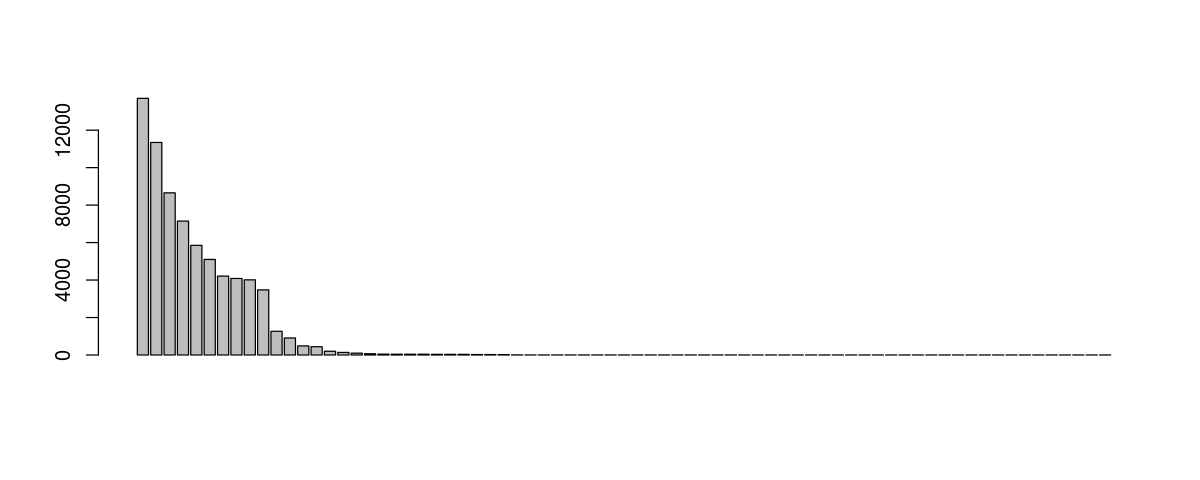

In [23]:
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(dangen97, names.arg='')

What do we see with our 95% radius?

In [24]:
aa95 <- subset_samples(biom95.nonc, SampleNumber == 'PosG')
dangen95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
dangen95 <- sort(dangen95, decreasing = TRUE)
length(dangen95)

[1] 72

Basically the same. Can we track down which OTU's were included in mock community and which are probably contaminants? To do this, let's find the sequences from the illumina positive control samples and blast them against the sanger sequences from our pure cultures that were included in the mock community. 

In [ ]:
## create a list of names of otus in our illumina positive control:
#sink('dangen95names.txt')
#names(dangen95)
#sink()

The above file is then modified with a text editor to give us the names of the otu in the proper format to feed to a python script that queries these otu names output a fasta file. Script is here:

In [ ]:
#! /usr/bin/env python3

## our big ass list of otu names from our illumina positive control

mcseq=("OTU127:12Leaf","OTU139:161wood","OTU181:104Leaf","OTU155:122Leaf",
"OTU210:161wood","OTU234:161wood","OTU246:161wood","OTU230:70Leaf",
"OTU3:H_notatum","OTU305:74Leaf","OTU285:161wood","OTU254:161wood",
"OTU304:161wood","OTU472:161wood","OTU347:NC.1Leaf","OTU499:102Leaf",
"OTU700:161wood","OTU2984:161wood","OTU2576:161wood","OTU247:112.2Leaf",
"OTU7019:256wood","OTU3247:161wood","OTU6368:161wood","OTU3549:161wood",
"OTU641:161wood","OTU7236:161wood","OTU959:162wood","OTU5820:125Leaf",
"OTU8816:162wood","OTU4059:162wood","OTU7923:256wood","OTU529:121Leaf",
"OTU251:202wood","OTU9517:256wood","OTU8178:161wood","OTU923:110Leaf",
"OTU163:66Leaf","OTU235:131Leaf","OTU10117:256wood","OTU1767:163wood",
"OTU695:107Leaf","OTU8736:161wood","OTU2330:102Leaf","OTU9282:104Leaf",
"OTU165:119Leaf","OTU102:88Leaf","OTU62:81Leaf","OTU581:85Leaf",
"OTU241:164wood","OTU568:164wood","OTU258:164wood","OTU603:216wood",
"OTU67:14Leaf","OTU1126:199wood","OTU1053:165wood","OTU841:237wood",
"OTU341:165wood","OTU1061:71Leaf","OTU1224:117Leaf","OTU1253:52Leaf",
"OTU452:75Leaf","OTU774:167wood","OTU4233:174wood","OTU5933:241wood",
"OTU947:192wood","OTU1260:170wood","OTU229:81Leaf","OTU3194:253wood",
"OTU378:197wood","OTU2099:252wood","OTU1235:254wood","OTU1599:254wood")

## get our reference otu fasta into memory:
with open('otus_95_combo_asstax.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if mcseq[j] in line:
                                goop.write(line)
                                for l in refseq[i+1:i+5]:
                                        if ">" in l:
                                                goop.write('\n')
                                                break
                                        goop.write(l)

Entries in the output file from this look this: 

In [1]:
head mcseq.txt

>OTU127:12Leaf;size=30160;tax=d:Fungi(1.0000),p:Ascomycota(0.9986),c:Sordariomycetes(0.8957),o:Coniochaetales(0.8682),f:Coniochaetaceae(0.8579);
CAAGAAGCCGAAAGGCTACTTCAAACCATCGCGAACTCGTCCAAGTTGCTTCGGCGGCGCGGCACCCCTTAACGGGGGCG
CCGCAGCCCTGCCTCTCCGGAGGTTCGGGGCGCCCGCCGGAGGTACGAAACTCTGTATTATAGTGGCATCTCTGAGTATA
AAACAAATAAGTTA

>OTU139:161wood;size=26544;tax=d:Fungi(1.0000),p:Ascomycota(1.0000),c:Dothideomycetes(0.9689),o:Dothideales(0.9760),f:Incertae_sedis(0.9691),g:Phaeocryptopus(0.9761),s:Phaeocryptopus_gaeumannii_SH206781.07FU;
CTGAGTGAGGGCTTCGGTCCGACCTCCAACCCTTTGTGAACCAAACTTGTTGCTTCGGGGGCGACCCTGCCGCCACGGCG
GCGCGGCGCCCCCGAAGGCCATCAAACACTGCATCATTGCGTCGGAGTTAAAGTAAATCAAATA

>OTU181:104Leaf;size=18704;tax=d:Fungi(1.0000),p:Ascomycota(0.9936),c:Dothideomycetes(0.9079),o:Capnodiales(0.8867),f:Mycosphaerellaceae(0.8672),g:Mycosphaerella(0.4066),s:Mycosphaerella_rubella_SH206848.07FU;


We can clean these up with SED:

In [3]:
sed '/^>/ s/;size=.*//' mcseq.txt > sed '/^>/ s/;size=.*//' mcseq.txt > mockseqs.fasta

In [4]:
head mockseqs.fasta

>OTU127:12Leaf
CAAGAAGCCGAAAGGCTACTTCAAACCATCGCGAACTCGTCCAAGTTGCTTCGGCGGCGCGGCACCCCTTAACGGGGGCG
CCGCAGCCCTGCCTCTCCGGAGGTTCGGGGCGCCCGCCGGAGGTACGAAACTCTGTATTATAGTGGCATCTCTGAGTATA
AAACAAATAAGTTA

>OTU139:161wood
CTGAGTGAGGGCTTCGGTCCGACCTCCAACCCTTTGTGAACCAAACTTGTTGCTTCGGGGGCGACCCTGCCGCCACGGCG
GCGCGGCGCCCCCGAAGGCCATCAAACACTGCATCATTGCGTCGGAGTTAAAGTAAATCAAATA

>OTU181:104Leaf


These will be used as our query sequences. Now we need a database to query against. This will be the fasta file that we received when we sanger-sequenced each of the pure cultures that ultimately went into our mock community. We'll use the  [blastn algorithm/software](https://www.ncbi.nlm.nih.gov/books/NBK279690/) to do our search, which means we need to make a database in the format that blastn likes, then conduct our search. 

In [5]:
## my sanger sequences are in an obscure location. Make a friendly symbolic link:
ln -s /home/daniel/Documents/Taiwan_data/wood/mock_community/BioI-6098_OConnor_34875/BioI-6098_OConnor_34875.seq.txt mcsanger.fasta
## make our database for blast:
makeblastdb -in mcsanger.fasta -dbtype nucl -logfile dberrors.txt
## run blast search:
blastn -query mockseqs.fasta -db mcsanger.fasta -out mcblast.txt -num_descriptions 3 -num_alignments 3 ## text summary
blastn -query mockseqs.fasta -db mcsanger.fasta -out mcblast.csv -outfmt 10 -max_target_seqs 1 ## csv, more parsible

The second blast search above gives us a csv that we can use in R as a dataframe. Looks like this:

In [2]:
head mcblast.csv -n 3

OTU127:12Leaf,Sample10_ITS4,100.00,174,0,0,1,174,482,309,4e-91, 322
OTU139:161wood,Sample1_ITS4,99.31,144,1,0,1,144,434,291,7e-73, 261
OTU181:104Leaf,Sample8_ITS4,100.00,143,0,0,1,143,451,309,5e-74, 265


 But we need to add a header, and clean it up a little to make it more useful. The [default columns](https://www.ncbi.nlm.nih.gov/books/NBK279675/) have been outputted from blastn, we'll add the official abbreviations for these:

In [ ]:
## add header
sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast.csv > mcblasthead.csv
sed 's/_ITS[1,4],/,/g' mcblasthead.csv -i
sed 's/Sample//g' mcblasthead.csv -i

Now it looks this: 

In [3]:
head mcblasthead.csv -n 3

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU127:12Leaf,10,100.00,174,0,0,1,174,482,309,4e-91, 322
OTU139:161wood,1,99.31,144,1,0,1,144,434,291,7e-73, 261


Let's go back to R, read this in:

In [ ]:
blast <- read.csv("mcblasthead.csv")

<a id='deseq'></a>

## Variance stabilization of our reads

It's important to [stabilize the variance](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531of) of our combined-leaf-and-wood-endophyte read depths, we'll do this using the [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) package in R. This is a way of making the samples, which have highly variable numbers of reads in them, comparable for downstream statistical analyses.

For the moment, we will repeat Roo's pipeline that he used to lay the groundwork for his other analyses with the leaf-only data. We want to treat this new data as similarly as possible. His first step was to remove controls and low-read (<2000) samples. 

How many samples have less than 2000 reads in our biom table?

In [23]:
sample_sums(biom95.nonc)[sample_sums(biom95.nonc) < 2000]

255wood  NC_2Leaf    86Leaf  NC_1Leaf    18Leaf    67Leaf 112_1Leaf 113_2Leaf 
        0         0       562         0      1403      1376         1         3 
   74Leaf 113_1Leaf 126_2Leaf    91Leaf     Strom 
      289        45         2         6        51

Not many. Some of these needed to be removed anyway, the negative controls and the low-read "\_" reads, which represented empty samples included in the run. 

In [24]:
biom95_hiread <- prune_samples(sample_sums(biom95.nonc)>=2000, biom95)

Did this work? 

In [25]:
sample_sums(biom95_hiread)[sample_sums(biom95_hiread) < 2000]

named numeric(0)

Nada. Worked. Now remove controls. We'll work more with the mock communities and other positive controls in the future. The leaves did not contain a positive control, so this is out of the scope of Roo's analysis. 

In [26]:
biom95_hiread_nocontrol <- subset_samples(biom95_hiread, SorC=="Sample")

In [27]:
head(sample_data(biom95_hiread_nocontrol)); tail(sample_data(biom95_hiread_nocontrol))

,Library,SampleNumber,SorC
164wood,W,1,Sample
165wood,W,2,Sample
166wood,W,3,Sample
167wood,W,4,Sample
168wood,W,5,Sample
169wood,W,7,Sample


,Library,SampleNumber,SorC
47Leaf,L,47,Sample
39Leaf,L,39,Sample
5Leaf,L,5,Sample
28Leaf,L,28,Sample
19Leaf,L,19,Sample
3Leaf,L,3,Sample


Roo has written a function to stream-line the process of using deseq variance stabilization, because it was originally written for RNA-seq data, with dense matrices. Species matrices are usually pretty sparse, so deseq needs a few workarounds to handle our kind of data. Thankfully, Roo has worked on this, and saved me probably weeks of work. His function looks like this: 


In [28]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object

        # Set variables to NULL
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL

        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)

        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }

        geo_Means = apply(counts(deseq), 1, gm_mean)

        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on

                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)

                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0

                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)

                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq

                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)

                # return the new phyloseq object
                return(phyloseq.DESeq)

        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}

} # end function


So let's try it out on our data. DESeq asks for an experimental design to incorporate in its modeling of read counts. In this instance, we are making comparisons of the relative importance of the origins of our endophytes - are wood endophytes or leaf endophytes more predictive of decomposers (stromata) at a given site? With this question, I believe the design variable is the origin of the sample, leaf or wood, (our "Library" metadata variable). 

In [29]:
## match Roo's random seed set, not sure if this is necessary for DeSeq but let's err on the side of caution
set.seed(28132)

In [30]:
deseq95 <- DESeq_varstab(biom95_hiread_nocontrol, ~Library)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Roo's function goes into DESeq land and back, returning us a phyloseq object. How does our data look after touching the void and coming back to us?

In [32]:
deseq95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7035 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 7035 taxa by 7 taxonomic ranks ]

In [33]:
biom95_hiread_nocontrol

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10271 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10271 taxa by 7 taxonomic ranks ]

Looks like we lost some taxa. Let's compare the distributions of our read depths before and after variance stabilization:

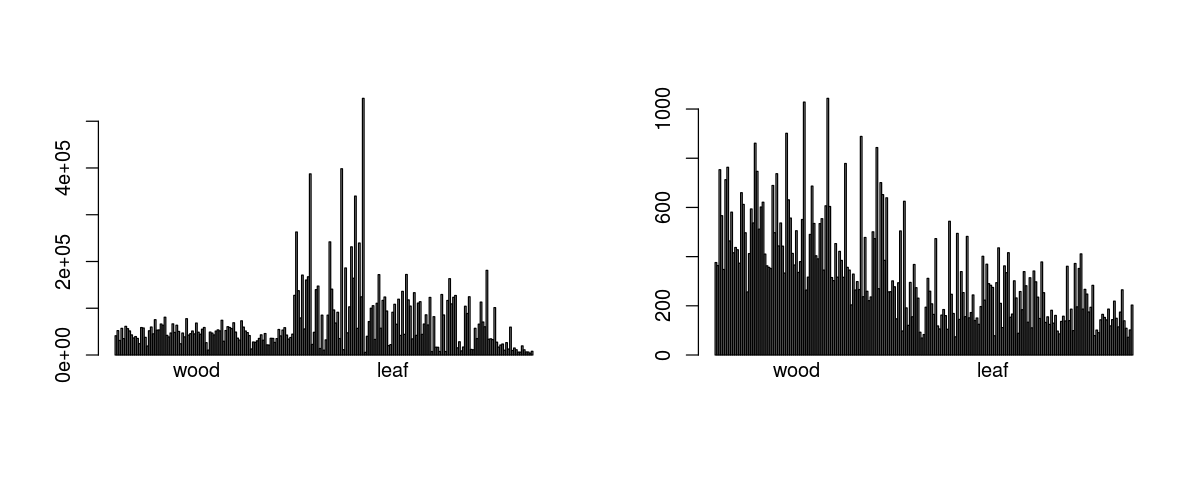

In [34]:
par(mfrow = c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

barplot(sample_sums(biom95_hiread_nocontrol), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

barplot(sample_sums(deseq95), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

Huh, it looks like the wood retained more reads than the leaves. I'm a bit confused by this and our low read numbers in general after variance stabilization. Maybe this is due to the very different abundances present between the two studies.  

# Redundancy analysis

<a id='rdaprep'></a>

# Formatting and transforming data for RDA

To examine the relative importances of leaf and wood endophytes in predicting decomposer (stromata) populations, we'll employ [Redundancy analysis](https://sites.google.com/site/mb3gustame/constrained-analyses/rda). This is a constrained, direct-gradient type of analysis that is kind of like a multiple regression of a response (Y) matrix to several explanatory (X) matrices.  

One of the nice things about RDA is that it is constrained, meaning that it focuses on the variation in our response matrix that can be explained by the variables we supply, though there is some estimation of unexplained variation. We do not expect that all or even most of the variation in our decomposer matrix will be explained by either the leaf or wood endophyte populations. Much of the variation is probably due to environmental conditions, etc. But here we check to see if any variation in our decomposers can be predicted by endophytes, and if so, the relative importance of our leaf and wood endophytes. 

### Formatting inputs for RDA

For our RDAs, we'll need three matrices. Our "y" matrix will be the observations of stromata from our sites. The "x" matrices will be our wood and leaf species matrices. All three will need to be of the same sites, meaning we need to trim down to the smallest matrix. This is our wood matrix, which had successful DNA purification and amplification in only 91 samples.

**Wood matrix**

To get our wood samples which contained Xylariaceae:

In [36]:
wood95 <- subset_samples(deseq95, Library=='W') ## wood samples only
Xwood95 <- subset_taxa(wood95, Family=='Xylariaceae') ## subset to Xyalriaceae
Xwoodmat <- t(otu_table(Xwood95)@.Data) ## get our species matrix out
Xwoodmat <- Xwoodmat[,colSums(Xwoodmat) > 0] ## get rid of empty columns

Looks like this:

In [37]:
Xwoodmat[1:10,1:5]

,OTU1:X_hypoxylon_Oregon,OTU254:161wood,OTU304:161wood,OTU3:H_notatum,OTU7:A_aff_atroroseum
164wood,0.000000,0.0000000,0,0,0
165wood,1.523625,0.0000000,0,0,0
166wood,0.000000,0.0000000,0,0,0
167wood,0.000000,0.0000000,0,0,0
168wood,0.000000,0.0000000,0,0,0
169wood,0.000000,0.0000000,0,0,0
170wood,0.000000,0.0000000,0,0,0
171wood,0.000000,0.4978564,0,0,0
172wood,0.000000,1.1388586,0,0,0
173wood,2.860447,0.6830260,0,0,0


Nice, but let's rename our rows by their actual sample number, not the names that the illumina software gave them.

In [43]:
Xwoodnames <- sample_data(Xwood95)@.Data[[2]] ## note, this number may change if metadata reassigned
rownames(Xwoodmat) <- Xwoodnames
Xwoodmat[1:10,1:5]

,OTU1:X_hypoxylon_Oregon,OTU254:161wood,OTU304:161wood,OTU3:H_notatum,OTU7:A_aff_atroroseum
1,0.000000,0.0000000,0,0,0
2,1.523625,0.0000000,0,0,0
3,0.000000,0.0000000,0,0,0
4,0.000000,0.0000000,0,0,0
5,0.000000,0.0000000,0,0,0
7,0.000000,0.0000000,0,0,0
9,0.000000,0.0000000,0,0,0
10,0.000000,0.4978564,0,0,0
11,0.000000,1.1388586,0,0,0
13,2.860447,0.6830260,0,0,0


Notice that some rows are missing, where sampling was unsucessful. We need to create a leaf matrix and trim to these samples, since we can only compare among the three matrices where all were sampled.

**Leaf matrix**

Get the matrix as with the wood above:

In [ ]:
leaf95 <- subset_samples(deseq95, Library=='L')  ## leaves only
Xleaf95 <- subset_taxa(leaf95, Family=='Xylariaceae')
Xleafmat <- t(otu_table(Xleaf95)@.Data) ## leaf species matrix
Xleafmat <- Xleafmat[,colSums(Xleafmat) > 0] ## get rid of empty columns
Xleafnames <- sample_data(Xleaf95)@.Data[[2]] ## get sample numbers. This number may change if metadata reassigned

In [ ]:
## get rid of "_" character in two of our sample names:
w1 <- which(Xleafnames ==  '112_2')
Xleafnames[w1] <- '112'
w2 <- which(Xleafnames ==  '126_1')
Xleafnames[w2] <- '126'

In [54]:
rownames(Xleafmat) <- Xleafnames

In [49]:
Xleafmat[1:10,1:5]

,OTU1:X_hypoxylon_Oregon,OTU304:161wood,OTU3:H_notatum,OTU7:A_aff_atroroseum,OTU2530:87Leaf
100,0.000000,0.000000,1.566253,0.8325197,0
78,0.000000,0.000000,0.000000,2.3942565,0
97,4.492057,0.000000,0.000000,0.0000000,0
90,8.826932,0.000000,0.000000,0.0000000,0
27,0.000000,0.000000,0.000000,0.0000000,0
21,4.966793,0.000000,1.240632,4.1004389,0
88,0.000000,2.021768,0.000000,0.0000000,0
104,0.000000,0.000000,0.000000,0.0000000,0
81,1.797142,0.000000,0.000000,0.0000000,0
112,0.000000,0.000000,0.000000,0.0000000,0


In all the processing, the sample order was totally lost in the leaf reads. Fix this:

In [55]:
bb <- sort(as.numeric(rownames(Xleafmat))) ## create a vector of sorted row names
cc <- as.character(bb) ##turn them back into characters
Xleafmat <- Xleafmat[cc,] ## use them to sort our matrix
Xleafmat[1:10,1:3] ## take a look

,OTU1:X_hypoxylon_Oregon,OTU304:161wood,OTU3:H_notatum
1,0.0000000,0,0
2,0.0000000,0,0
3,0.0000000,0,0
4,0.0000000,0,0
5,0.0000000,0,0
6,0.0000000,0,0
7,0.0000000,0,0
8,0.0000000,0,0
9,0.0000000,0,0
12,0.6871609,0,0


**Stromata matrix**

The stromata data are in a csv, compiled by Roo:

In [60]:
stromata <- as.matrix(read.csv(file='stromata.csv'))
## our rownames were imported as the first column of the matrix, fix this:
rownames(stromata) <- stromata[,1] 
stromata <- stromata[,-1] ## drop this original first row of names

In [144]:
stromata[1:10,1:5]

,A_aff_atroroseum,A_aff_stygium,A_atroroseum,A_bovei_var_microspora,A_moriforme
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,0


Notice, no gaps in the sample numbers in this matrix. We completed sampling for stromata at all plots, so this matrix has the most samples.

In [61]:
dim(stromata)

[1] 133  52

**Pruning matrices** 

We can only make statements about samples where all three matrices have data. Right now, each of our matrices has a slightly different set of samples included within it, resulting in different numbers of rows:

In [63]:
dim(Xwoodmat)
dim(Xleafmat)
dim(stromata)

[1] 91 95

[1] 122 185

[1] 133  52

So we need to prune all matrices down to only the rows (samples) that all three matrices contain. First, we prune our wood and leaf matrices to each other:

In [65]:
Xwoodmat <- Xwoodmat[rownames(Xwoodmat) %in% rownames(Xleafmat), ]
Xleafmat <- Xleafmat[rownames(Xleafmat) %in% rownames(Xwoodmat), ]

Our stromata matrix also needs to be pruned to match our wood/leaves:

In [66]:
stromata <- stromata[rownames(stromata) %in% rownames(Xleafmat), ]

Do they all have the same number of rows? Are these row numbers identical?

In [67]:
dim(Xwoodmat)
dim(Xleafmat)
dim(stromata)

[1] 81 95

[1]  81 185

[1] 81 52

In [71]:
any(rownames(Xwoodmat) != rownames(Xleafmat)); any(rownames(Xwoodmat) != rownames(stromata))

[1] FALSE

[1] FALSE

**Convert to Presence/Absence data**

Doing to this because I do not trust our read abundances or stromata counts to be ecologically meaningful. See notes [here](#mockcom).

In [72]:
Xwoodmat[Xwoodmat > 0] <- 1
Xleafmat[Xleafmat > 0] <- 1
stromata[stromata > 0] <- 1

In [73]:
sum(Xwoodmat)
sum(Xleafmat)
sum(stromata)

[1] 232

[1] 742

[1] 39

Redundancy analysis is a type of PCA of our response (stromata) matrix coupled with a multiple regression of our explanatory matrix, in this case either our wood or leaf endophyte matrices. (RDA is obviously a lot more complicated than this, involving construction of new axes informed by both explanatory and response variable, see [here](#https://sites.google.com/site/mb3gustame/constrained-analyses/rda)). Since this can be considered a type of multiple regression and PCA analysis, we run into some obstacles. PCA analysis relies on Euclidean distances for its construction of new axes, and multiple regression works best when the explanatory variables can be modeled linearly, or at least ordered in rank abundance. But it's pretty well known that species distributions aren't modeled well as linear gradients. Along a single environmental gradient they may follow unimodal, gaussian distibutions, but in really sparse matrices like we have, with incomplete sampling of thousands of interacting species instead of one, and in the finite space of a single study with environmental variables varying at different spatial scales, this type of normality can be pretty hard to pick up. Also the numerous zeroes in these matrices make very different sampling sites look very similar in normal euclidean space, [the double zero problem](#https://sites.google.com/site/mb3gustame/reference/dissimilarity).

So we'll standardize and flatten out differences in abundances in our species matrices using a [Hellinger transformation](#http://www.jstor.org/stable/4223083). In doing so we hope to reduce the homogenizing effect of having lots of zeroes in all sites and retain monotonic properties, if not linearity, to our abundance data (which we've already reduced to presence-absence). The RDA can then proceed with these transformed values to create new axes that are shared by both our explanatory and response matrices, using euclidean distances. At least, that's the theory...

In [77]:
stromata.hel <- decostand(stromata,'hellinger')
Xwoodmat.hel <- decostand(Xwoodmat,'hellinger')
Xleafmat.hel <- decostand(Xleafmat,'hellinger')

In [79]:
#save(stromata.hel, file='stromata.hel.rda')
#save(Xwoodmat.hel, file='Xwoodmat.hel.rda')
#save(Xleafmat.hel, file='Xleafmat.hel.rda')

<a id='rda'></a>

# Redundancy Analysis

**Stromata as a function of entire wood endophyte community**

In [81]:
wood.rda <- rda(stromata.hel, Xwoodmat.hel) ## run the rda
anova.cca(wood.rda) ## check for significance

,Df,Variance,F,Pr(>F)
Model,64,0.27071621,0.9601912,0.541
Residual,16,0.07048497,NA,NA


If I've used this command correctly, the leaf endophytes explain a lot of variance in the stromata matrix, but we have no confidence (p = 0.54!). I'm guessing this is due to low statistical power, especially in our small and sparse stromata matrix. But let's do a biplot and examine which species are suggested by the RDA to explain variance in the stromata:

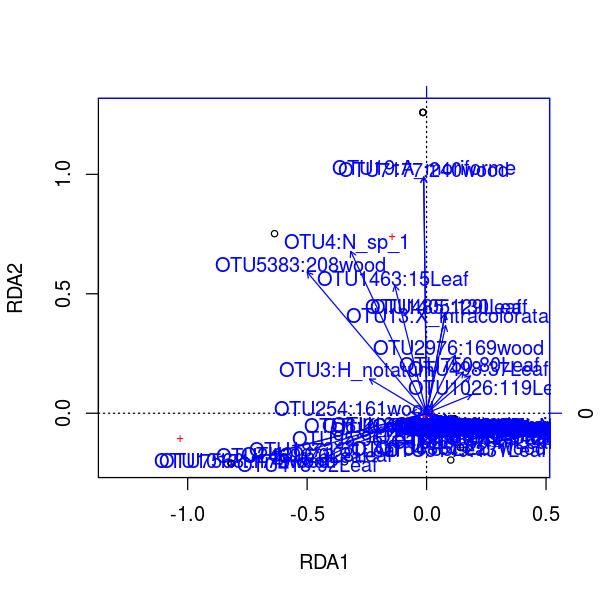

In [118]:
options(repr.plot.width = 5, repr.plot.height = 5)
woodrdaplot <- plot(wood.rda)

Well, that's a mess. Moving on. 

**Stromata as a function of entire leaf endophyte community**

In [84]:
leaf.rda <- rda(stromata.hel, Xleafmat.hel) ## run the rda
anova.cca(leaf.rda) ## check for significance

,Df,Variance,F,Pr(>F)
Model,77,0.3318262,1.379018,0.378
Residual,3,0.0093750,NA,NA


As above, we have no confidence in the model as a whole. But we can still glean info from this.

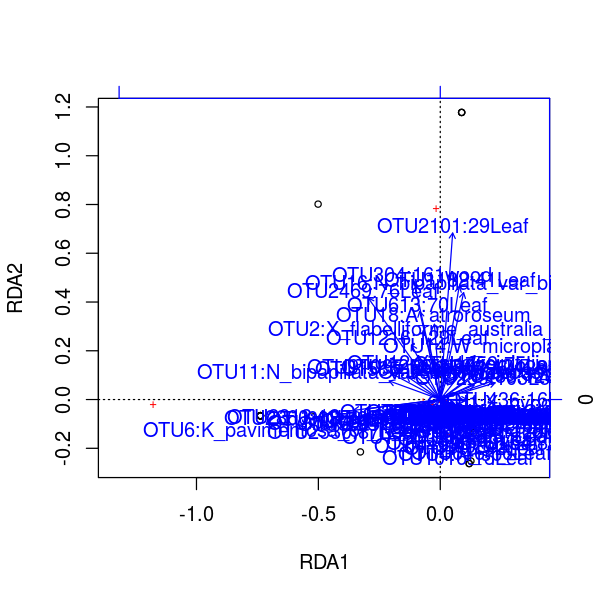

In [119]:
options(repr.plot.width = 5, repr.plot.height = 5)
leafrdaplot <- plot(leaf.rda)

Again, a big mess. 

In this plot, species from our wood matrix are arrows. RDA is a type of constrained analysis, so the wood endophyte species are being used in the construction of the two most important PCA's (RDA's) that are our two axes. The longer the arrow, the more important they are for these new RDA axes. Hence, the longer arrows indicate which leaf endophytes seem to be co-varying with our stromata community.

To get a general idea of importance, let's make a function that shows us the most important (longest) species arrows in the space of these two RDA axes:

In [90]:
rdadist <- function(plot, howmany){
        bb <- plot$biplot
        RDAdist <- sqrt((bb[,'RDA1'])^2+(bb[,'RDA2'])^2)
        cc <- sort(RDAdist, decreasing = TRUE)[1:howmany]
        return(cc)
} 

The two arguments for this function are the rda plot object and how many species we'd like to include in our list. To see the ten most important species in our leaf community in predicting stromata:

In [123]:
rdadist(leafrdaplot,5)

OTU2101:29Leaf                      OTU2469:76Leaf 
                          0.5198914                           0.3868913 
                     OTU304:161wood                      OTU1182:41Leaf 
                          0.3761448                           0.3565322 
OTU16:N_bipapillata_var_bipapillata 
                          0.3406239

To find out the taxonomic assignments for these:

In [124]:
aa <- rdadist(leafrdaplot,50)
cbind(tax_table(biom95)[names(aa),6:7],aa)

,Genus,Species,aa
OTU2101:29Leaf,Xylaria,NA,0.519891410822974
OTU2469:76Leaf,Kretzschmaria,pavimentosa,0.386891317146501
OTU304:161wood,Nemania,Nemania_aenea_SH217392.07FU,0.376144836781367
OTU1182:41Leaf,Muscodor,Muscodor_yucatanensis_SH195934.07FU,0.356532175747353
OTU16:N_bipapillata_var_bipapillata,Nemania,bipapillata_var_bipapillata,0.340623861368935
OTU6:K_pavimentosa_or_N_primolutea,Kretzschmaria,pavimentosa_or_N_primolutea,0.300996516412475
OTU613:70Leaf,Xylaria,NA,0.281540699696602
OTU2860:41Leaf,NA,NA,0.271839568833074
OTU154:85Leaf,NA,NA,0.252271618482018
OTU2530:87Leaf,Xylaria,NA,0.244157663321162


This may be a little misleading, because the most important axis by far is our first RDA. So if we check the most important species on this axis:

In [96]:
sort(abs(leafrdaplot$biplot[,'RDA1']), decreasing=TRUE)[1:10]

aa <- names(sort(abs(leafrdaplot$biplot[,'RDA1']), decreasing=TRUE)[1:10])
tax_table(biom95)[aa,6:7]

OTU6:K_pavimentosa_or_N_primolutea                     OTU2860:41Leaf 
                         0.2905086                          0.2697516 
                   OTU2313:127Leaf                     OTU2530:87Leaf 
                         0.2325623                          0.2318899 
                     OTU154:85Leaf                     OTU2469:76Leaf 
                         0.2262931                          0.2238929 
                    OTU1873:51Leaf                      OTU908:70Leaf 
                         0.2062729                          0.2005025 
                    OTU485:129Leaf                     OTU396:128Leaf 
                         0.1707274                          0.1679327

,Genus,Species
OTU6:K_pavimentosa_or_N_primolutea,Kretzschmaria,pavimentosa_or_N_primolutea
OTU2860:41Leaf,NA,NA
OTU2313:127Leaf,Xylaria,atrosphaerica
OTU2530:87Leaf,Xylaria,NA
OTU154:85Leaf,NA,NA
OTU2469:76Leaf,Kretzschmaria,pavimentosa
OTU1873:51Leaf,Hypoxylon,Hypoxylon_monticulosum_SH213380.07FU
OTU908:70Leaf,NA,NA
OTU485:129Leaf,Muscodor,Muscodor_fengyangensis_SH195936.07FU
OTU396:128Leaf,Xylaria,Xylaria_allantoidea_SH194350.07FU


Odd, some otus didn't cluster to our stromata, but the usearch taxonomic assignment then assigned them the same taxonomy as one of these sequences (I inserted them into our version of the UNITE database). Not sure how that works. For instance, OTU2313:127Leaf is an independent cluster from any of our stromata, but the closest match from the UNITE/stromata database was our *K. pavimentosa* sequence. Not sure what to do with this.

**Stromata as a function of shared wood endophyte community only**

It seems perhaps inapropriate to use species that are not represented in all matrices, not sure. To do that is to ask questions about species-species interactions, better addressed with co-occurence analysis. Also, I think we lose all ability by the RDA to detect any patterns. So let's constrain our analysis to just Xylariaceous taxa observed as stromata. 

We need to reformat our column names to match, then can subset our leaf and wood community matrices to just those species that are also observed somewhere as a stromata.

In [ ]:
## wood 
Xwm2 <- Xwoodmat.hel
aa <- colnames(Xwm2) ## get names of stromata, but have "otu:" in front
bb <- strsplit(aa, split=':') ## split by colon symbol
cc <- unlist(bb) ## unroll the list
woodnames <- cc[1:length(cc) %% 2 == 0] ## takes the even numbers 
colnames(Xwm2) <- woodnames
#cbind(colnames(Xwm2), woodnames) ## looks okay
Xwm.strom <- Xwm2[,colnames(Xwm2) %in% colnames(stromata)] ##subset

Okay, we've now simplified our wood endophyte community matrix to just those species that were observed somewhere in our study as xylareacious stromata. Looks like, after my pipeline, there are 17 shared species between the wood endophytes and stromata communities:

In [108]:
dim(Xwm.strom) #how many Xylariaceae wood endos are also in stromatal matrix? 
dim(Xwm2) ## how many Xylariaceae were in the wood, in general.

[1] 81 17

[1] 81 95

Okay, let's run the RDA with just these shared fungi:

In [116]:
wood.stromonly.rda <- rda(stromata.hel, Xwm.strom)
anova.cca(wood.stromonly.rda)

,Df,Variance,F,Pr(>F)
Model,16,0.0867612,1.363955,0.139
Residual,64,0.2544400,NA,NA


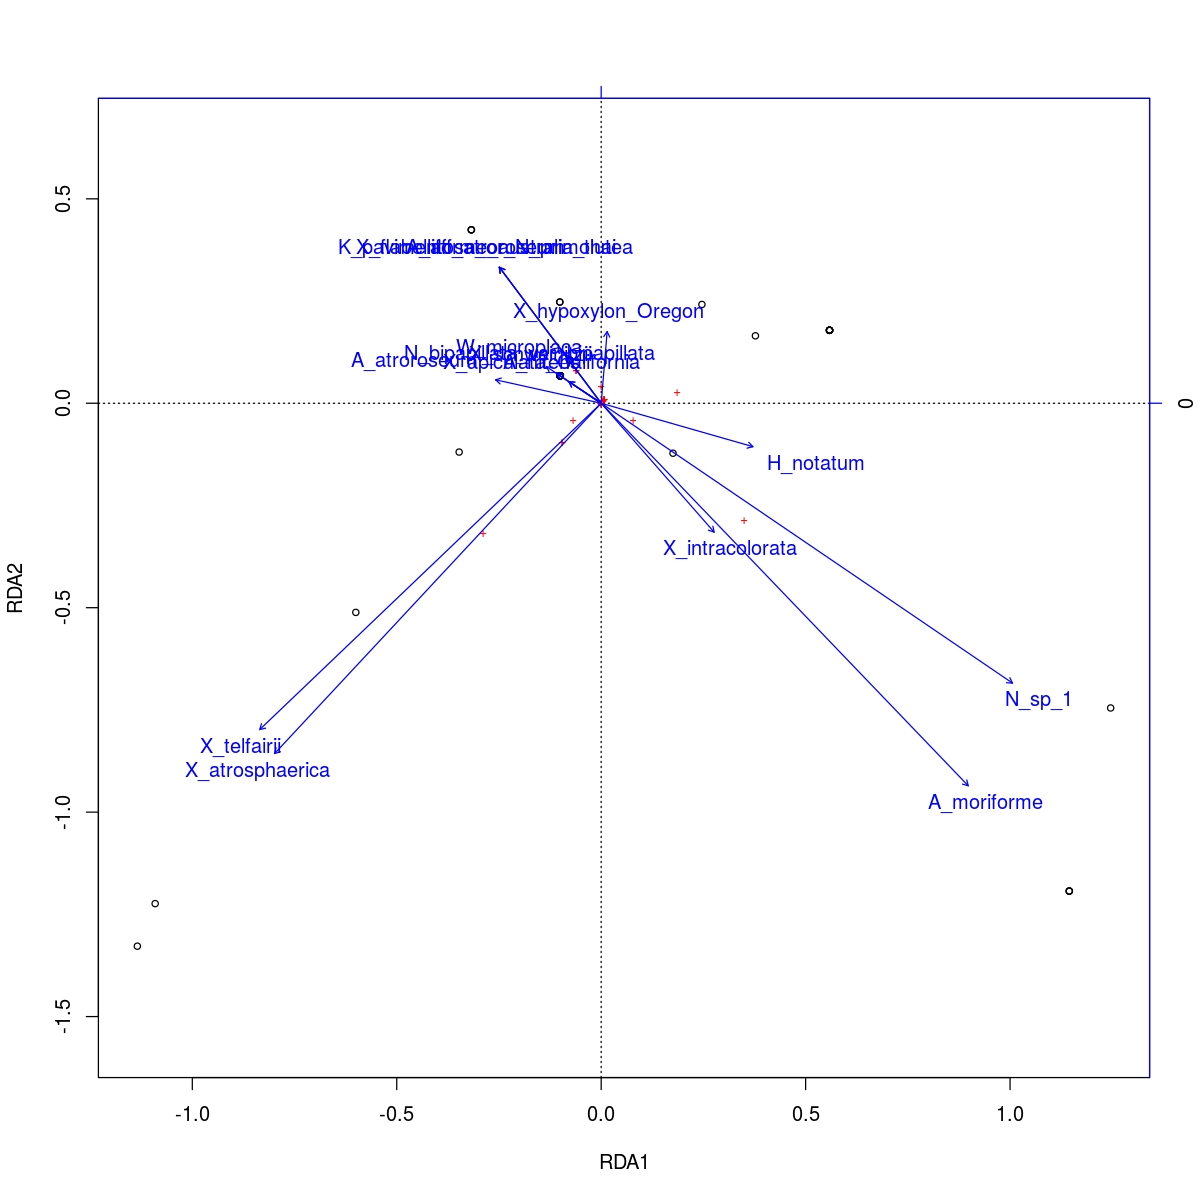

In [117]:
wood.stromonly.rda.plot <- plot(wood.stromonly.rda)

**Stromata as a function of shared leaf endophyte community only**

In [110]:
## leaf 
Xlm2 <- Xleafmat.hel
aa <- colnames(Xlm2) ## get names of stromata, but have "otu:" in front
bb <- strsplit(aa, split=':') ## split by colon symbol
cc <- unlist(bb) ## unroll the list
leafnames <- cc[1:length(cc) %% 2 == 0] ## takes the even numbers 
colnames(Xlm2) <- leafnames
#cbind(colnames(Xlm2), leafnames) ## looks good
Xlm.strom <- Xlm2[,colnames(Xlm2) %in% colnames(stromata)]

In [112]:
dim(Xlm.strom) #how many Xylariaceae leaf endos are also in stromatal matrix? 
dim(Xlm2) #how many Xylariaceae leaf endos were there in general? 

[1] 81 24

[1]  81 185

Run the RDA with these matrices:

In [114]:
leaf.stromonly.rda <- rda(stromata.hel, Xlm.strom)
anova.cca(leaf.stromonly.rda)

,Df,Variance,F,Pr(>F)
Model,22,0.1128537,1.302941,0.091
Residual,58,0.2283475,NA,NA


Plot it:

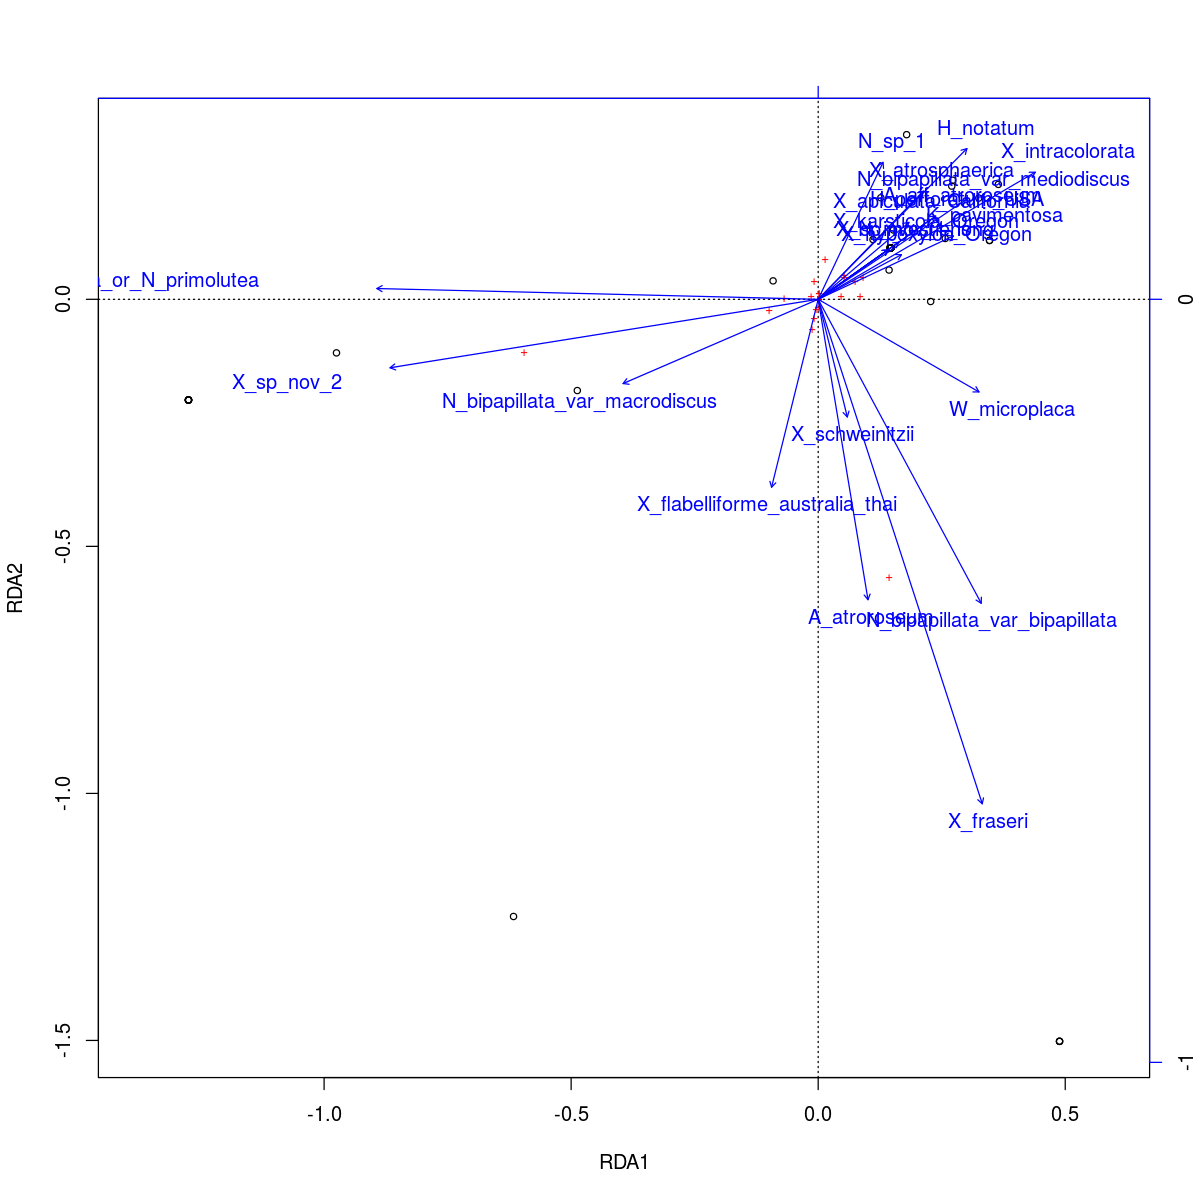

In [115]:
leaf.stromonly.rda.plot <- plot(leaf.stromonly.rda)